# Tutorial 1: Basics of CrypTen Tensors

We now have a high-level understanding of how secure MPC works. Through these tutorials, we will explain how to use CrypTen to carry out secure operations on encrypted tensors. In this tutorial, we will introduce a fundamental building block in CrypTen, called a ```CrypTensor```.  ```CrypTensors``` are encrypted ```torch``` tensors that can be used for computing securely on data. 

CrypTen currently only supports secure MPC protocols (though we intend to add support for other advanced encryption protocols). Using the ```mpc``` backend, ```CrypTensors``` act as ```torch``` tensors whose values are encrypted using secure MPC protocols. Tensors created using the ```mpc``` backend are called ```MPCTensors```. We will go into greater detail about ```MPCTensors``` in Tutorial 2. 

Let's begin by importing ```crypten``` and ```torch``` libraries. (If the imports fail, please see the installation instructions in the README.)

In [1]:
import crypten
import torch
from crypten.config import cfg
import timeit
import crypten.communicator as comm
import logging
import matplotlib.pyplot as plt
import numpy as np

crypten.init()
# logging.getLogger().setLevel(logging.INFO)

# torch.set_num_threads(1)

# comm.get().set_verbosity(True)
# ... do stuff ..
# comm.get().print_communication_stats()

In [2]:
def print_diff(x, z_enc):
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    print(f"TAE: {diff.sum():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
    # print(diff[:print_terms])
    plt.plot(diff)
    
def print_diff_numb(x, z_enc):
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    print(f"TAE: {diff.sum():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
num_iters = 1
print_terms = 1

def print_app(name, end_time, start_time):
    print(f"  {name}: {num_iters} iterations in {end_time - start_time} sec.") # : {z_enc.get_plain_text()[:print_terms]}")


## Initial tests

In [3]:
import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_sum():
    x_enc = crypten.cryptensor(torch.arange(5, 15, 1))   
    # m = torch.arange(3, 10, 1)   
    crypten.print("\nx is:", x_enc.get_plain_text())
    y_enc = x_enc.mod(4)
    crypten.print("\ny is:", y_enc.get_plain_text())

test_sum()


x is: tensor([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

y is: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


[None, None]

## Negative exp

torch.Size([64000])
Negative Exponential:
  Approx: 1 iterations in 0.022330458014039323 sec.
TAE: 7.149363e-05, MRE: 8.482303e-01, MAX: 3.611863e-03
  Bior: 1 iterations in 0.03994020802201703 sec.
TAE: 3.848229e-05, MRE: 8.755276e-01, MAX: 4.234135e-03


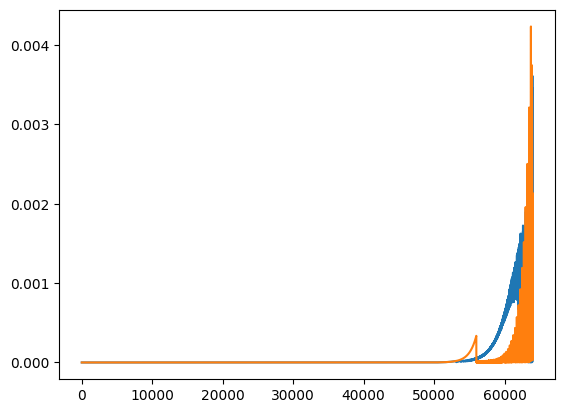

In [3]:
#Construct example input CrypTensor
x = torch.arange(-64, 0, 0.001)
# x = x.reshape([1600, 10])
print(x.size())
# x = torch.tensor([0.01, 0.5])
x_enc = crypten.cryptensor(x)

print("Negative Exponential:")
# print("  Exact :", x.exp()[:print_terms])
with cfg.temp_override({"functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
# with cfg.temp_override({"functions.exp_method": 'split', "functions.exp_all_neg": True}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.exp()  # Private
#     # print("  Nexp   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Nexp", timeit.default_timer(), start1)
#     print_diff(x.exp(), z_enc)
# with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": True}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.exp()  # Private
#     # print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Haar", timeit.default_timer(), start1)
#     print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": True}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    # print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(x.exp(), z_enc)

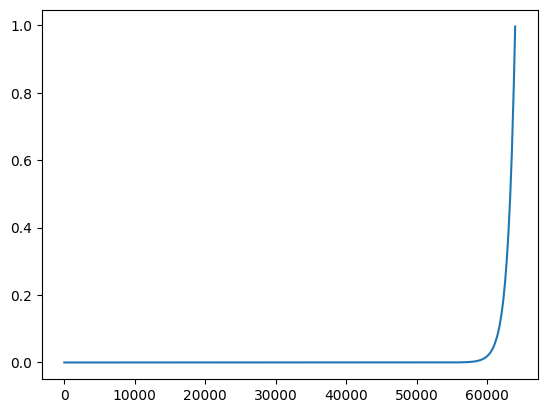

In [4]:
plt.plot(z_enc.get_plain_text())

In [3]:
#Construct example input CrypTensor
x = torch.arange(-8, 8, 0.3)
print(x.size())
# x = torch.tensor([0.01, 0.5])
x_enc = crypten.cryptensor(x)

print("Exponential:")
print("  Exact :", x.exp()[:print_terms])
with cfg.temp_override({"functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": False}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": False}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)

torch.Size([54])
Exponential:
  Exact : tensor([0.0003])
  Approx: 1 iterations in 0.010859876998438267 sec.: tensor([0.0003])
TAE: 9.896224e+02, MRE: 4.457789e-02, MAX: 3.100916e+02
  Haar  : 1 iterations in 0.0106402130004426 sec.: tensor([1.0158])
TAE: 1.361802e+07, MRE: 5.348339e+05, MAX: 6.203709e+06
  Bior  : 1 iterations in 0.007976648999829195 sec.: tensor([0.0071])
TAE: 1.656615e+04, MRE: 8.443229e+02, MAX: 4.394732e+03


In [4]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_exp():
    #Construct example input CrypTensor
    # x = torch.arange(start=0.001, end=10, step=0.001)
    x = torch.arange(-8, 8, 0.3)
    print(x.size())
    # x = torch.tensor([0.01, 0.5])
    x_enc = crypten.cryptensor(x)

    print("Exponential:")
    print("  Exact :", x.exp()[:print_terms])
    with cfg.temp_override({"functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": False}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": False}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)

test_exp()

torch.Size([54])torch.Size([54])

Exponential:Exponential:

  Exact :  Exact :  tensor([0.0003])
tensor([0.0003])
  Approx:  Approx:  1 1iterations in  iterations in0.020749635999891325  sec.:0.024158725998859154  sec.:tensor([0.0003]) 
tensor([0.0003])
TAE: 9.584272e+02, MRE: 4.141982e-02, MAX: 2.967222e+02TAE: 9.584272e+02, MRE: 4.141982e-02, MAX: 2.967222e+02



KeyboardInterrupt: 

## Reciprocal

Checked


Reciprocal:
  Approx: 1 iterations in 0.10779731799993897 sec.
TAE: 1.650533e-01, MRE: 1.117153e-02, MAX: 9.487513e-04, ARGMAX: 626
  Log: 1 iterations in 0.18898794800043106 sec.
TAE: 2.234099e-01, MRE: 1.945818e-03, MAX: 2.494347e-02, ARGMAX: 2
  Haar: 1 iterations in 0.17676809900149237 sec.
TAE: 3.925454e-02, MRE: 4.505710e-04, MAX: 3.458679e-03, ARGMAX: 4
  Bior: 1 iterations in 0.03203584799848613 sec.
TAE: 7.844158e-02, MRE: 4.740021e-04, MAX: 2.110565e-02, ARGMAX: 0


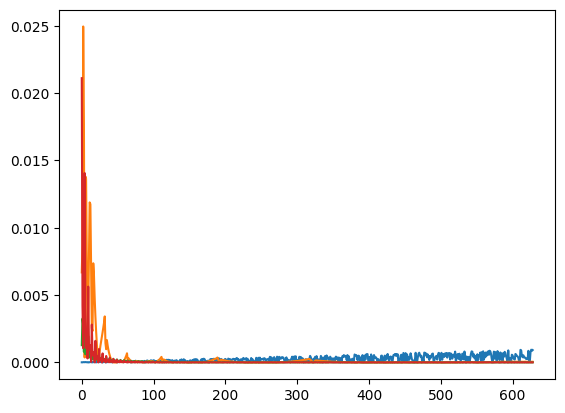

In [3]:
# x = torch.tensor([0.00005, 0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]) # , 5, 10, 50, 100 , 500, 1000, 5000, 10000, 50000])
x = torch.arange(start=1.1, end=64, step=0.1)
# x = torch.arange(start=1.01, end=10, step=0.01)
# x = x.reshape((63, 100))
x_enc = crypten.cryptensor(x)

print("\nReciprocal:")
# print("  Exact :", x.reciprocal()[:print_terms])
with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Log", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_rec():
    #Construct example input CrypTensor
    # x = torch.arange(start=0.001, end=10, step=0.001)
    # x = torch.tensor([0.00005, 0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]) # , 5, 10, 50, 100 , 500, 1000, 5000, 10000, 50000])
    # x = torch.arange(1.0, 64, 0.001)
    # x = torch.arange(start=1.01, end=10, step=0.01)
    x = torch.arange(start=1.01, end=64, step=0.01)
    x = torch.arange(start=1.0, end=64, step=0.1)
    # x = x.reshape((63, 100))
    x_enc = crypten.cryptensor(x)

    print("\nReciprocal:")
    # print("  Exact :", x.reciprocal()[:print_terms])
    with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Log", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)

test_rec()


Reciprocal:
Reciprocal:

  Approx: 1 iterations in 0.11487301899978775 sec.
  Approx: 1 iterations in 0.11597658000027877 sec.
TAE: 1.034085e-01, MRE: 7.035718e-03, MAX: 8.707121e-04, ARGMAX: 625TAE: 1.034085e-01, MRE: 7.035718e-03, MAX: 8.707121e-04, ARGMAX: 625

  Log: 1 iterations in 0.2395357170025818 sec.  Log: 1 iterations in 0.2341324720000557 sec.

TAE: 1.763754e+00, MRE: 4.040836e-02, MAX: 9.576416e-02, ARGMAX: 6TAE: 1.763754e+00, MRE: 4.040836e-02, MAX: 9.576416e-02, ARGMAX: 6

  Haar: 1 iterations in 0.33160046500051976 sec.
  Haar: 1 iterations in 0.33917227699930663 sec.
TAE: 1.131594e-01, MRE: 8.426440e-04, MAX: 1.397979e-02, ARGMAX: 1TAE: 1.131594e-01, MRE: 8.426440e-04, MAX: 1.397979e-02, ARGMAX: 1

  Bior: 1 iterations in 0.08076992300266284 sec.  Bior: 1 iterations in 0.08915126400097506 sec.

TAE: 1.486271e-01, MRE: 5.674919e-04, MAX: 3.615081e-02, ARGMAX: 1TAE: 1.486271e-01, MRE: 5.674919e-04, MAX: 3.615081e-02, ARGMAX: 1



[None, None]

## Logarithm

Checked


Logarithm (LUT faster):
  Exact : tensor([-6.9078])
  Approx: 1 iterations in 0.3177104860005784 sec.: tensor([-9.6244])
TAE: 2.844735e+03, MRE: 1.482003e-01, MAX: 6.207399e+00, ARGMAX: 86
  Haar  : 1 iterations in 0.9049433489999501 sec.: tensor([-5.1546])
TAE: 3.662082e+01, MRE: 4.709653e-03, MAX: 1.753169e+00, ARGMAX: 0
  Bior  : 1 iterations in 0.22671682500003953 sec.: tensor([-8.3834])
TAE: 1.225648e+02, MRE: 2.323973e-03, MAX: 2.842553e+00, ARGMAX: 9


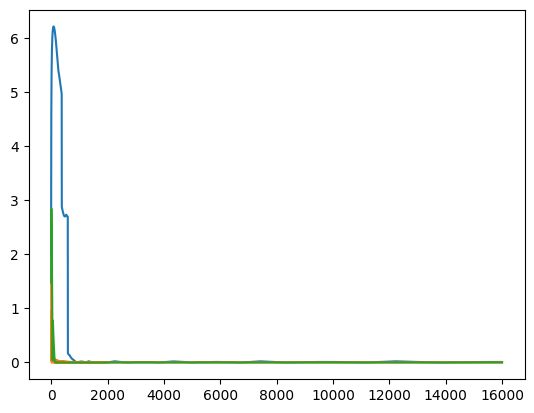

In [3]:
x = torch.arange(0.001, 16, 0.001)
x_enc = crypten.cryptensor(x)

print("\nLogarithm (LUT faster):")
print("  Exact :", x.log()[:print_terms])
with cfg.temp_override({"functions.log_method": 'iter'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)
with cfg.temp_override({"functions.log_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)
with cfg.temp_override({"functions.log_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)
def test_log():
    rank = comm.get().get_rank()
    print("Rank is: ", rank)
    # x = torch.arange(5, 15, 1)
    x = torch.arange(start=0.01, end=16, step=0.01)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    # print("  x :", x) if rank == 0 else None
    # print("  Exact :", x.log()) if rank == 0 else None
    with cfg.temp_override({"functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text()) 
        # if rank == 0:
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.log(), z_enc)
    with cfg.temp_override({"functions.log_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        # if rank == 0:
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.log(), z_enc)
    with cfg.temp_override({"functions.log_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        # if rank == 0:
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.log(), z_enc)

test_log()

Rank is: Rank is:   01


Logarithm (LUT faster):
Logarithm (LUT faster):

  Approx:  Approx:  11  iterations initerations in  1.3059166950006331.3147731739991286  sec.:sec.:  tensor([-9.5224])tensor([-9.5224])

TAE: 6.321122e+02, MRE: 3.310408e-01, MAX: 3.143586e+01, ARGMAX: 725
TAE: 6.321122e+02, MRE: 3.310408e-01, MAX: 3.143586e+01, ARGMAX: 725
  Haar  :  Haar  :  11 iterations in  iterations in0.18130578300042544  0.22710179800196784sec.:  sec.:tensor([-3.7722]) 
tensor([-3.7722])
TAE: 6.462055e+00, MRE: 7.293875e-03, MAX: 8.329229e-01, ARGMAX: 0TAE: 6.462055e+00, MRE: 7.293875e-03, MAX: 8.329229e-01, ARGMAX: 0

  Bior  : 1 iterations in  Bior  :  0.32409941299920321  sec.:iterations in  0.3213185819986393tensor([-7.4477]) 
sec.: tensor([-7.4477])
TAE: 3.791651e+01, MRE: 8.545389e-03, MAX: 1.333700e+01, ARGMAX: 1597TAE: 3.791651e+01, MRE: 8.545389e-03, MAX: 1.333700e+01, ARGMAX: 1597



[None, None]

## Sqrt

torch.Size([16000])

Square Root: (LUT faster)
  Exact : tensor([0.])
  Approx: 1 iterations in 0.11007783099921653 sec.: tensor([0.])
TAE: 3.313608e-03, MRE: 1.877052e-03, MAX: 3.947655e-02
  Haar   : 1 iterations in 1.0206637120008963 sec.: tensor([0.0834])
TAE: 9.728398e-04, MRE: 1.177351e-03, MAX: 8.338928e-02
  Bior   : 1 iterations in 0.04207055499864509 sec.: tensor([0.0594])
TAE: 9.331023e-04, MRE: 2.952432e-03, MAX: 7.328644e-02


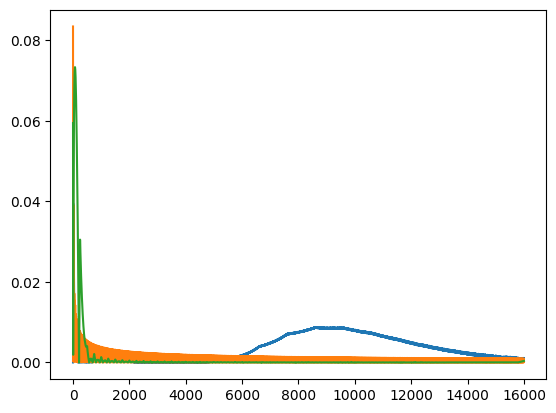

In [11]:
x = torch.arange(0.0, 16, 0.001)
print(x.size())
x_enc = crypten.cryptensor(x)

print("\nSquare Root: (LUT faster)")
print("  Exact :", x.sqrt()[:print_terms])
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sqrt(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt(), z_enc)

## Inv sqrt

torch.Size([63999])

Inverse Square Root: (LUT faster)
  Exact : tensor([31.6228])
  Approx: 1 iterations in 0.07845383300445974 sec.: tensor([6.6806])
TAE: 2.356224e-03, MRE: 5.628088e-04, MAX: 2.494213e+01
  Haar   : 1 iterations in 0.9241446670203004 sec.: tensor([7.9092])
TAE: 4.136174e-03, MRE: 1.317897e-03, MAX: 2.371356e+01
  Bior   : 1 iterations in 0.9291922080155928 sec.: tensor([132.9271])
TAE: 6.281005e-02, MRE: 9.881573e-03, MAX: 1.097883e+02


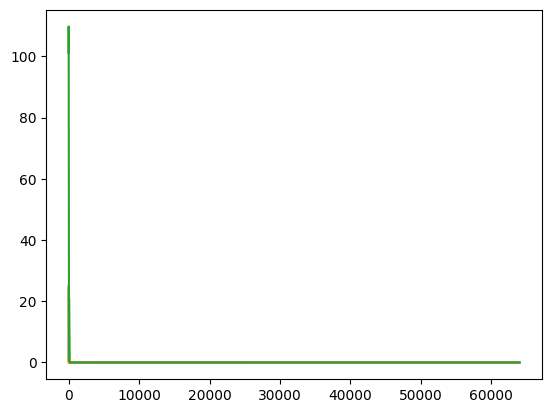

In [9]:
x = torch.arange(0.001, 64, 0.001)
print(x.size())
x_enc = crypten.cryptensor(x)

print("\nInverse Square Root: (LUT faster)")
print("  Exact :", x.sqrt().reciprocal()[:print_terms])
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sqrt().reciprocal(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt().reciprocal(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt().reciprocal(), z_enc)

## Sin

In [3]:
import crypten.mpc as mpc
# x = torch.arange(0, 64, 0.001)
# x = torch.rand((2, 2))
# x = torch.arange(1, 10, 1)
# print(x.size())
# x_enc = crypten.cryptensor(x)
# print("Ref tensor: ", x.sin())

@mpc.run_multiprocess(world_size=2)
def test_sin():
    rank = 0
    x = torch.arange(5, 15, 1)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    print("  x :", x) if rank == 0 else None
    print("  Exact :", x.sin()) if rank == 0 else None
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        crypten.print("Out NR tensor: ", z_enc.get_plain_text())
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print_diff(x.sin(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print_diff(x.sin(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print_diff(x.sin(), z_enc)

test_sin()


Logarithm (LUT faster):
Logarithm (LUT faster):

  x :   x : tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
  Exact :tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]) 
  Exact :tensor([-0.9589, -0.2794,  0.6570,  0.9894,  0.4121, -0.5440, -1.0000, -0.5366,
         0.4202,  0.9906])
 tensor([-0.9589, -0.2794,  0.6570,  0.9894,  0.4121, -0.5440, -1.0000, -0.5366,
         0.4202,  0.9906])
Out NR tensor:  tensor([-0.9719, -0.2838,  0.6702,  1.0220,  0.4297, -0.5744, -1.0565, -0.5718,
         0.4607,  1.0919])
Divisor is:Divisor is:  tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Divisor is:Divisor is:  tensor([-41432726165770877,  42158948415758425,  35241072275423853,
         -5173557652924395,  31188413171221407,  39345300831215025,
         15340923686131579, -29151363286662963,  15318462353780713,
           314232836311818])
tensor([-41432726165770877,  42158948415758425,  35241072275423853,
         -5173557652924395,  3118841

[None, None]

## Cos


Cos:
  Exact : tensor([1.])
  Approx: 1 iterations in 0.13763970899162814 sec.: tensor([1.])
TAE: 8.897241e-01, MRE: 1.959649e+00, MAX: 5.938161e+00
  Haar  : 1 iterations in 0.23780120798619464 sec.: tensor([0.9998])
TAE: 4.957701e-03, MRE: 5.930695e-02, MAX: 1.567387e-02
  Bior  : 1 iterations in 0.04329570900881663 sec.: tensor([1.0026])
TAE: 1.336654e-03, MRE: 3.306064e-03, MAX: 5.173981e-03


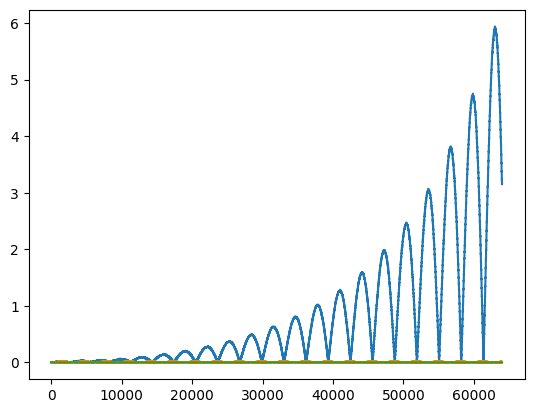

In [11]:
print("\nCos:")
print("  Exact :", x.cos()[:print_terms])
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)

## Sigmoid

Checked

NOTE: In practice, Haar is more stable for any combination of elements in the range [-64, 64] when the world_size is 2.


Sigmoid:
  Exact : tensor([1.6038e-28])
  Approx: 1 iterations in 0.07519824900009553 sec.: tensor([1.5259e-05])
TAE: 9.223650e-02, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.07909449900034815 sec.: tensor([0.])
TAE: 4.223196e-02, MRE: 1.341260e+00, MAX: 1.953125e-03, ARGMAX: 640
  Bior  : 1 iterations in 0.04319244699945557 sec.: tensor([0.])
TAE: 1.213635e-02, MRE: 1.341115e+00, MAX: 4.950166e-04, ARGMAX: 655


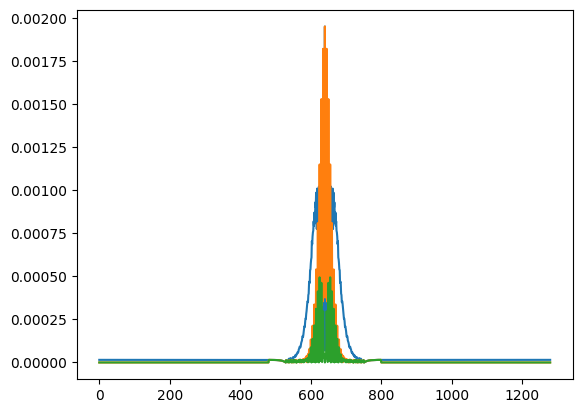

In [4]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("\nSigmoid:")
print("  Exact :", x.sigmoid()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_sig():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("\nSigmoid:")
    print("  Exact :", x.sigmoid()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc) 

test_sig()


Sigmoid:
Sigmoid:

  Exact :  Exact :  tensor([1.6038e-28])tensor([1.6038e-28])

  Approx:  Approx:  11 iterations in  0.09048607600198011 iterations in 0.08454993899795227sec.:  sec.: tensor([1.5259e-05])tensor([1.5259e-05])

TAE: 8.629784e-02, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640
TAE: 8.629784e-02, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640
  Haar  :  Haar  :  11  iterations initerations in  0.275852529997791860.26969732900033705  sec.:sec.:  tensor([0.])tensor([0.])

TAE: 8.982444e-02, MRE: 1.341180e+00, MAX: 4.315674e-03, ARGMAX: 648
TAE: 8.982444e-02, MRE: 1.341180e+00, MAX: 4.315674e-03, ARGMAX: 648
  Bior  :  Bior  :  11  iterations initerations in  0.365025339000567330.368415881999681  sec.:sec.:  tensor([0.])
tensor([0.])
TAE: 1.132634e+00, MRE: 3.125977e+03, MAX: 5.498809e-01, ARGMAX: 482TAE: 1.132634e+00, MRE: 3.125977e+03, MAX: 5.498809e-01, ARGMAX: 482



[None, None]

## Tanh

Checked

NOTE: In practice, Haar is more stable for any combination of elements in the range [-64, 64] when the world_size is 2.

Tanh:
  Exact : tensor([-1.])
  Approx: 1 iterations in 0.05020815199895878 sec.: tensor([-1.0000])
TAE: 1.099896e-01, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.07190768700093031 sec.: tensor([-1.])
TAE: 4.133090e-02, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640
  Bior  : 1 iterations in 0.034640937999938615 sec.: tensor([-1.])
TAE: 4.329973e-02, MRE: 9.059697e+07, MAX: 3.687888e-03, ARGMAX: 635


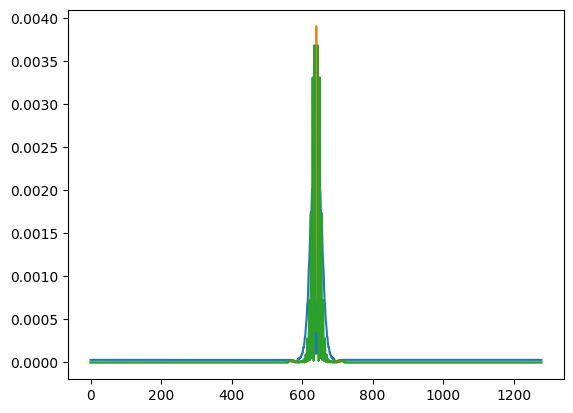

In [3]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("Tanh:")
print("  Exact :", x.tanh()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_tanh():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("Tanh:")
    print("  Exact :", x.tanh()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)

test_tanh()

Tanh:
Tanh:  Exact :
   Exact : tensor([-1.])
tensor([-1.])
  Approx:  Approx:  11  iterations initerations in  0.081107286998303610.0830144410028879 sec.:  sec.:tensor([-1.0000]) 
tensor([-1.0000])
TAE: 1.067391e-01, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640TAE: 1.067391e-01, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640

  Haar  :  Haar  :  11  iterations in iterations in0.3401949609979056  sec.:0.33790166300241253  tensor([-1.])
sec.: tensor([-1.])
TAE: 9.512509e-02, MRE: 8.589935e+08, MAX: 8.646607e-03, ARGMAX: 636TAE: 9.512509e-02, MRE: 8.589935e+08, MAX: 8.646607e-03, ARGMAX: 636

  Bior  :  Bior  :  11  iterations initerations in  0.3292540949987597 0.3295351529995969sec.:  sec.: tensor([-1.])
tensor([-1.])
TAE: 1.309977e+00, MRE: 9.059697e+07, MAX: 1.098327e+00, ARGMAX: 561TAE: 1.309977e+00, MRE: 9.059697e+07, MAX: 1.098327e+00, ARGMAX: 561



[None, None]

## Erf

Checked

Erf:
  Exact : tensor([-1.])
  Approx: 1 iterations in 0.09889762999955565 sec.: tensor([98524.9453])
TAE: 1.036244e+11, MRE: 8.095657e+07, MAX: 2.921903e+08, ARGMAX: 18
  Haar  : 1 iterations in 0.09378300000025774 sec.: tensor([-1.])
TAE: 2.057946e-02, MRE: 4.282105e+08, MAX: 2.197266e-03, ARGMAX: 640
  Bior  : 1 iterations in 0.045994402000360424 sec.: tensor([-1.])
TAE: 1.187288e-02, MRE: 5.947368e+06, MAX: 1.167595e-03, ARGMAX: 635


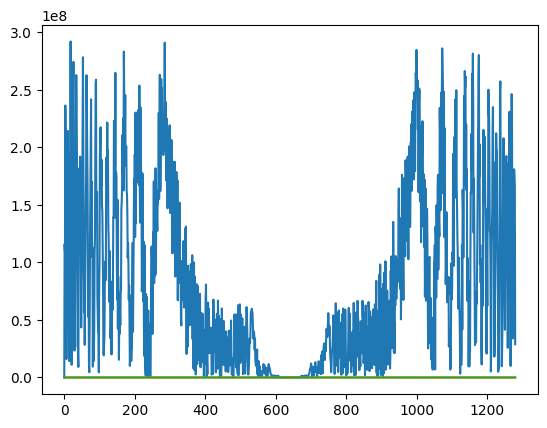

In [6]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("Erf:")
print("  Exact :", x.erf()[:print_terms])
with cfg.temp_override({"functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)
with cfg.temp_override({"functions.erf_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)
with cfg.temp_override({"functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_erf():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("Erf:")
    print("  Exact :", x.erf()[:print_terms])
    with cfg.temp_override({"functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)
    with cfg.temp_override({"functions.erf_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)
    with cfg.temp_override({"functions.erf_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)

test_erf()

Erf:Erf:

  Exact :  Exact :  tensor([-1.])tensor([-1.])

  Approx:  Approx:  11  iterations initerations in  0.19139540800097166 0.18667985499996576sec.:  sec.:tensor([98524.9453]) 
tensor([98524.9453])
TAE: 2.857417e+11, MRE: 2.232357e+08, MAX: 4.270002e+09, ARGMAX: 783TAE: 2.857417e+11, MRE: 2.232357e+08, MAX: 4.270002e+09, ARGMAX: 783

  Haar  :  Haar  :  11  iterations initerations in 0.3228094139994937  0.32281961199987563sec.:  sec.:tensor([-1.])
 tensor([-1.])
TAE: 4.695722e-02, MRE: 4.282105e+08, MAX: 4.118025e-03, ARGMAX: 636TAE: 4.695722e-02, MRE: 4.282105e+08, MAX: 4.118025e-03, ARGMAX: 636

  Bior  :  Bior  :  11  iterations initerations in  0.27057230699938370.27326086700122687  sec.:sec.:  tensor([-1.])tensor([-1.])

TAE: 5.322316e-02, MRE: 5.947368e+06, MAX: 6.532520e-03, ARGMAX: 643TAE: 5.322316e-02, MRE: 5.947368e+06, MAX: 6.532520e-03, ARGMAX: 643



[None, None]

## Gelu


Gelu:
  Exact : tensor([-0.0000, -0.0000, -0.0000,  ..., 63.9970, 63.9980, 63.9990])
  Approx: 1 iterations in 0.1556117500003893 sec.
TAE: 3.697499e+08, MRE: 5.910950e+10, MAX: 1.073699e+09
  Erf: 1 iterations in 0.08925287501187995 sec.
TAE: 1.407880e-04, MRE: 3.115182e-02, MAX: 1.158456e-02
  Haar: 1 iterations in 0.2509989999816753 sec.
TAE: 4.481751e-05, MRE: 1.656812e+08, MAX: 7.675171e-03
  Bior: 1 iterations in 0.06056291700224392 sec.
TAE: 2.911503e-05, MRE: 4.282018e+07, MAX: 3.939874e-03


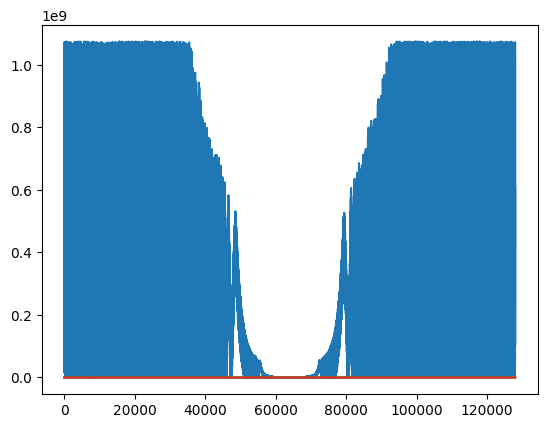

In [15]:
# x = torch.arange(start=1.01, end=10, step=0.01)
# x_enc = crypten.cryptensor(x)

gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
relu = x * (x > 0)

print("\nGelu:")
print("  Exact :", gelu)
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Erf", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)

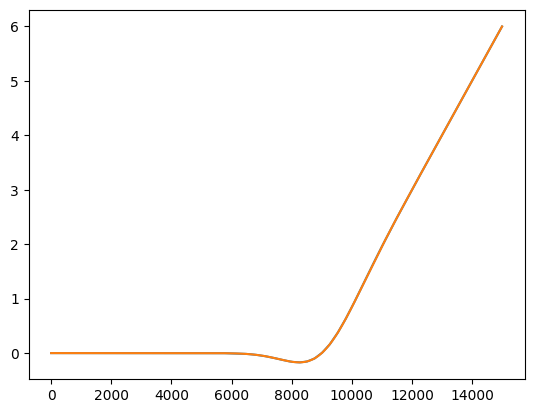

In [16]:
plt.plot(z_enc.get_plain_text()[55000:70000])
plt.plot(gelu[55000:70000])

## Silu


Silu:
  Approx: 1 iterations in 0.6332753750029951 sec.
TAE: 3.590142e-01, MRE: 5.488147e+23, MAX: 7.207108e-01
  Sigmoid: 1 iterations in 0.16468466699006967 sec.
TAE: 3.710410e-05, MRE: 1.351435e+00, MAX: 8.265972e-04
  Haar: 1 iterations in 1.751425124995876 sec.
TAE: 3.693916e-05, MRE: 4.545507e+07, MAX: 3.875732e-03
  Bior: 1 iterations in 0.15150779200484976 sec.
TAE: 2.601743e-05, MRE: 1.431656e+07, MAX: 2.574161e-03


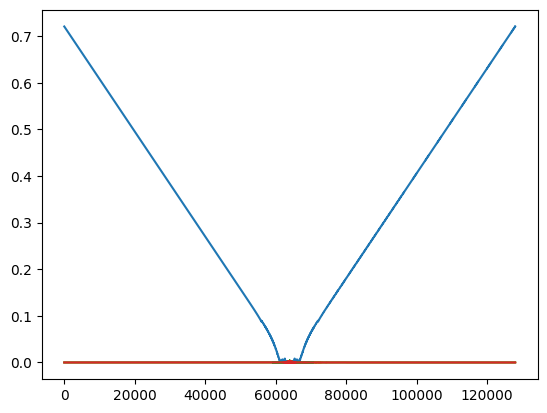

In [17]:
# x = torch.arange(-8, 8, 0.1)
# x_enc = crypten.cryptensor(x)

silu = x * x.sigmoid()
relu = x * (x > 0)

print("\nSilu:")
# print("  Exact :", silu)
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Sigmoid", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Privat6
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(silu, z_enc)

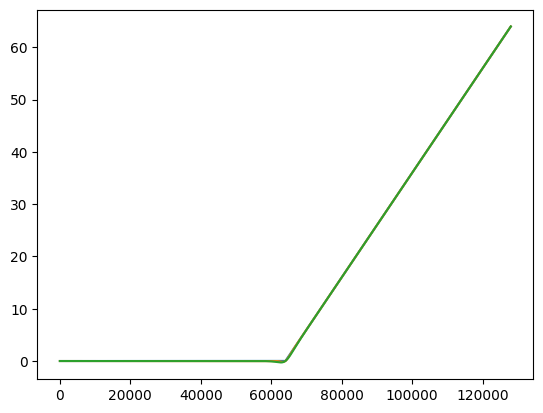

In [18]:
plt.plot(relu)
plt.plot(gelu)
plt.plot(silu)

#### Advanced mathematics
We are also able to compute more advanced mathematical functions on ```CrypTensors``` using iterative approximations. CrypTen provides MPC support for functions like reciprocal, exponential, logarithm, square root, tanh, etc. Notice that these are subject to numerical error due to the approximations used. 

Additionally, note that some of these functions will fail silently when input values are outside of the range of convergence for the approximations used. These do not produce errors because value are encrypted and cannot be checked without decryption. Exercise caution when using these functions. (It is good practice here to normalize input values for certain models.)